In [24]:
import listwise_ltr
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import numpy as np
# from evaluate import ndcg_at_k
import sys
sys.path.append('..')
import dataset

In [25]:
N_EPOCHS=10
DEVICE = 'cuda:0'

In [26]:
# class ListDataSet(Dataset):
    
#     def __init__(self, fold):
#         self.fold = fold
    
#     def __len__(self):
#         return self.fold.num_queries()
    
#     def __getitem__(self, index):
#         return self.fold.query_feat(index), self.fold.query_labels(index)

In [37]:
def ndcg(y_hat, y):
    
    def dcg(y_hat, y):
        sort_indices = y_hat.sort(descending=True)[1]
        
        return ( (2**y[sort_indices].float()-1) / torch.arange(2, len(y)+2).cuda().float().log() ).sum()
    norm = dcg(y, y)
    if norm == 0:
        return torch.tensor(1)
    else:
        return dcg(y_hat, y) / norm
    
def err(y_hat, y):
    R = y[y_hat.sort(descending=True).indices]
    Nd = len(R)
    
    phi = torch.arange(1,Nd+1).to(DEVICE)
    p = (2**R-1) / 2**4
    prob_stopping = torch.cumprod(1-p, 0) / (1-p[0]) * p
    return (prob_stopping/phi).sum()    


def delta_ndcg(y_hat, y):
    
    indices = y_hat.sort(descending=True).indices
    R_true = y.sort(descending=True).values
    R = y[indices]

    alpha = ( (2 ** R_true - 1) / torch.arange(2, len(y)+2).float().log2().to(DEVICE) ).sum()

    if alpha.item() == 0:
        return torch.ones_like(R)
    else:
        Nd = len(y_hat)

        Delta  = ((2**R-1).unsqueeze(1) / torch.arange(2, len(R)+2).float().log2().cuda() )
        ddcg = (Delta.sum(dim=1) + Delta.sum(dim=0) - Delta.diag() * Nd - Delta.diag().sum())/alpha
    
        return ddcg[indices] / alpha
    
    
def delta_err(y_hat, y):
    R = y[y_hat.sort(descending=True).indices]
    Nd = len(R)
    D = torch.zeros(Nd, Nd, Nd).to(DEVICE)
    
    phi = torch.arange(1,Nd+1).to(DEVICE)
    p = (2**R-1) / 2**4
    
    for i in range(Nd):
        for j in range(i+1, Nd):
            
            # swap indices
            p = p.clone()
            p[i], p[j] = p[j].item(), p[i].item()
                        
            prob_stopping = torch.cumprod(1-p, 0) / (1-p[0]) * p
            D[i,j,:] = D[j,i,:] = prob_stopping
    
    D = (D / phi).sum(dim=[1,2])
            
    return D


class LambdaRankFunction(torch.autograd.Function):
    
 
        
    
    @staticmethod
    def forward(ctx, y_hat, y, sigma, metric):
        
        S = (y.unsqueeze(1) - y.t()).clamp(-1, 1)
        D = y_hat.unsqueeze(1) - y_hat.t()
        
        ctx.save_for_backward(S, D, y_hat, y)
        ctx.sigma = sigma
        ctx.metric = metric
        
        loss = .5 * (1-S) * sigma * D + torch.log2(1+ torch.exp(-sigma*D))
            
        return loss.sum()
    
    @staticmethod
    def backward(ctx, grad_output):
        S, D, y_hat, y = ctx.saved_tensors
        
        Lambda = ctx.sigma * (.5 * (1-S) - 1 / (1+torch.exp(-ctx.sigma*D)))
        
        if ctx.metric == 'NDCG':
            dirm = delta_ndcg(y_hat, y)
        elif ctx.metric == 'ERR':
            dirm = delta_err(y_hat, y)
        else:
            raise NotImplementedError()
        
        dy_hat = Lambda.sum(dim=1) * dirm.abs()           
        
        return dy_hat, None, None, None


class LambdaRankLoss(torch.nn.Module):
    '''
    input: predictions and target
    output: scalar loss 
    '''
    
    def __init__(self, sigma, metric):
        assert metric in ['NDCG', 'ERR']
        
        super(LambdaRankLoss, self).__init__()
        self.sigma = sigma
        self.metric = metric
        
    
    def forward(self, y_hat, y):
        return LambdaRankFunction.apply(y_hat, y, self.sigma, self.metric)

    
    

In [28]:
data= dataset.get_dataset()
data.data_paths = ['../dataset']
data = data.get_data_folds()[0]
data.read_data()



In [29]:
np.random.seed(42)
torch.manual_seed(42)

In [30]:
train_dataset = dataset.ListDataSet(data.train)
valid_dataset = dataset.ListDataSet(data.validation)
test_dataset = dataset.ListDataSet(data.test)

In [31]:
train_dl = DataLoader(train_dataset, shuffle=True)
valid_dl = DataLoader(valid_dataset)
test_dl = DataLoader(test_dataset)

In [38]:
model = listwise_ltr.Listwise()
model.cuda()

optimizer = torch.optim.Adam(model.parameters())
critereon = LambdaRankLoss(sigma=1, metric='ERR')

In [39]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
sigmas = [0, 0.25, .5, 1.]
metrics = ['NDCG', 'ERR']

configs = [{'learning_rate':l, 'sigma':s, 'metric':m} for l in learning_rates for s in sigmas for m in metrics]

In [172]:
for i, config in tqdm(enumerate(configs), total=len(configs)):
    None



  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<?, ?it/s]

In [155]:
t=tqdm()


0it [00:00, ?it/s]

In [162]:
t.update()


7it [00:05,  1.70it/s]

In [143]:
32*4*10/60

21.333333333333332

In [40]:
train_loss = defaultdict(list)
valid_loss = defaultdict(list)
train_ndcg = defaultdict(list)
valid_ndcg = defaultdict(list)
train_err  = defaultdict(list)
valid_err  = defaultdict(list)


tqdm_str_format_train = 'TRAIN: loss: {0:.3f}\t NDCG: {1:.3f}\t ERR: {2:.3f}'
tqdm_str_format_valid = 'TRAIN: loss: {0:.3f}\t NDCG: {1:.3f}\t ERR: {2:.3f} \t VALID: loss: {3:.3f}\t NDCG: {4:.3f} \t ERR: {5:.3f}'

for epoch in range(N_EPOCHS):
    
    if early_stopping(valid_ndcg, patience=1):
        print('EARLY STOPPING')
        break
    
    # iterate over training set
    with tqdm(total=len(train_dl)) as t:
        model.train()
        t.set_description(f'Epoch: {epoch+1}/{N_EPOCHS}')
        for ix, (X,y) in enumerate(train_dl):
            X = X.cuda().float().squeeze(0)
            y = y.cuda().float().squeeze(0)

            y_hat = model(X).sigmoid().squeeze(1)
            
            # compute loss
            loss = critereon(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss[epoch].append(loss.item())
            ndcg_batch = ndcg(y_hat, y).item()
            err_batch = err(y_hat, y).item()
            
            train_ndcg[epoch].append(ndcg_batch)
            train_err[epoch].append(err_batch)
            
            if ix%50 == 0:
                t.set_postfix_str(tqdm_str_format_train.format(
                    loss.item(), ndcg_batch, err_batch
                ))
                
            if ix == 300:
                break
            
            t.update()
            
        mean_train_ndcg = np.mean(train_ndcg[epoch])
        mean_train_err  = np.mean(train_err[epoch])
        mean_train_loss = np.mean(train_loss[epoch])

        # validate
        with torch.no_grad():
            model.eval()
            for ix, (X,y) in enumerate(valid_dl):
                X = X.cuda().float().squeeze(0)
                y = y.cuda().float().squeeze(0)

                y_hat = model(X).sigmoid().squeeze(1)

                # compute loss
                loss = critereon(y_hat, y)
                ndcg_batch = ndcg(y_hat, y).item()
                err_batch = err(y_hat, y).item()
                
                valid_loss[epoch].append(loss.item())
                valid_ndcg[epoch].append(ndcg_batch)
                valid_err[epoch].append(err_batch)

                if ix % 50 == 0:
                    t.set_postfix_str(tqdm_str_format_valid.format(
                        mean_train_loss, mean_train_ndcg, mean_train_err, loss.item(), ndcg_batch, err_batch
                    ))
                    
                

        mean_valid_ndcg = np.mean(valid_ndcg[epoch])
        mean_valid_err  = np.mean(valid_err[epoch])
        mean_valid_loss = np.mean(valid_loss[epoch])
        
        t.set_postfix_str(tqdm_str_format_valid.format(
            mean_train_loss, mean_train_ndcg, mean_train_err, mean_valid_loss, mean_valid_ndcg, mean_valid_err
        ))
        
        
        
        
        
    

Epoch: 1/10:   0%|                  | 7/19943 [00:06<3:58:55,  1.39it/s, TRAIN: loss: 289.104	 NDCG: 0.457	 ERR: 0.091]


KeyboardInterrupt: 

In [44]:
p = torch.Tensor([1,4,8,0])

In [46]:
p[[0,1,3,2]]

tensor([1., 4., 0., 8.])

In [51]:
np.arange(4)

array([0, 1, 2, 3])

In [106]:
def delta_err2(y_hat, y):
    R = y[y_hat.sort(descending=True).indices]
    Nd = len(R)
    D = torch.zeros(Nd, Nd, Nd).to(DEVICE)
    
    phi = torch.arange(1,Nd+1).to(DEVICE)
    p = (2**R-1) / 2**4
    ind = np.arange(Nd)
    
    for i in range(Nd):
        for j in range(i+1, Nd):
            
            # swap indices
            
#             p2 = p.clone()
            ind[[i,j]] = ind[[j,i]]
                        
            prob_stopping = torch.cumprod(1-p[ind], 0) / (1-p[ind]) * p[ind]
            D[i,j,:] = D[j,i,:] = prob_stopping
    
    D = (D / phi).sum(dim=[1,2])
            
    return D

In [141]:
f"{np.mean(results['test_ndcg'])}"

NameError: name 'results' is not defined

In [121]:
p = torch.Tensor([1,4,8]) 

In [122]:
p = p.repeat(9, 1)

In [125]:
p2 = p.clone()

In [127]:
torch.arange(4)

tensor([0, 1, 2, 3])

In [138]:
p[[(0,0), (0,1)]]

tensor([1., 4.])

In [ ]:
p

In [103]:
%%time
z[0], z[1]

Wall time: 0 ns


In [72]:
z

array([1, 0, 2, 3])

In [107]:
%%time
delta_err(y_hat, y)

Wall time: 2.12 s


tensor([ 5.7130,  9.8260, 10.1584, 10.4416, 10.8547, 11.5613, 11.1972, 11.4431,
        11.4626, 11.6551, 11.5486, 11.5153, 11.6842, 11.6408, 11.7845, 11.7829,
        11.7837, 11.7930, 11.9067, 11.9897, 11.8857, 11.8686, 11.8000, 11.9714,
        11.8467, 11.8679, 11.8732, 12.0001, 11.9266, 11.9089, 11.9049, 11.8374,
        11.8070, 11.8493, 11.8633, 11.8706, 11.9992, 11.8585, 11.8784, 11.8819,
        11.8828, 12.0087], device='cuda:0')

In [109]:
%%time
delta_err2(y_hat, y)

Wall time: 2.04 s


tensor([21.9038, 19.0511, 16.7099, 15.4522, 14.7894, 14.6272, 14.0551, 13.8318,
        13.5978, 13.5214, 13.3592, 13.2559, 13.2524, 13.1527, 13.1678, 13.0944,
        13.0609, 13.0384, 13.0843, 13.0924, 13.0245, 13.0031, 12.9583, 13.0404,
        12.9609, 12.9729, 12.9719, 13.0353, 12.9873, 12.9763, 12.9720, 12.9369,
        12.9263, 12.9532, 12.9591, 12.9614, 13.0276, 12.9488, 12.9633, 12.9645,
        12.9646, 13.0299], device='cuda:0')

In [128]:
diff = np.array([-9.01721072e-04, -4.22556106e-05, -2.73978435e-05,  1.54022049e-03, -9.92962661e-03])

In [132]:
cur_epoch = len(diff)+1;cur_epoch

6

In [130]:
# diff = np.array([])
last_improvement = len(diff) - diff[::-1].argmax()
last_improvement

4

In [123]:
np.where(np.array([0, .1, .05])>0)[0].argmax()+2

3

In [22]:
def early_stopping(valid_results, patience = 0, objective = 'max'):
    '''
    Returns True is valid_loss did not increase for the last 'patience' epochs.

    params:
        valid_results: dictionary with the validation metric results per epoch
        patience: number of allowed epochs without improvement
        mode: whether to maximize or minimize the  metric

    '''
    
    if len(valid_results) <= 1:
        return False
    
    means = [np.mean(valid_results[epoch]) for epoch in valid_results]
    cur_epoch = len(means)
    diff = np.diff(means)
    
    print(means, diff)
    
   
    if objective == 'max':
        last_improvement = len(diff) - diff[::-1].argmax() + 1
    elif objective == 'min':
        last_improvement = len(diff) - diff[::-1].argmin() + 1
    else:
        raise NotImplementedError()
    
    stop = cur_epoch - last_improvement > patience

    return stop

In [42]:
means= [np.mean(valid_ndcg[epoch]) for epoch in valid_ndcg]

In [58]:
cur_epoch = len(means)

In [51]:
diff = np.diff(means)

In [60]:
last_increase = np.where(diff>0)[0].argmax() + 2

In [62]:
cur_epoch - last_increase > 0

False

In [22]:
def evaluate(model, dataloader):
    test_loss = list()
    test_ndcg = list()
    test_err  = list()

    with tqdm(total=len(dataloader)) as t:
        with torch.no_grad():
            model.eval()
            for ix, (X,y) in enumerate(dataloader):
                X = X.cuda().float().squeeze(0)
                y = y.cuda().float().squeeze(0)

                y_hat = model(X).sigmoid().squeeze(1)

                # compute loss
                loss = critereon(y_hat, y)
                ndcg_batch = ndcg(y_hat, y).item()
                err_batch = err(y_hat, y).item()
                test_loss.append(loss.item())
                test_ndcg.append(ndcg_batch)
                test_err.append(err_batch)
                
                t.update()
                if ix % 50 == 0:
                    t.set_postfix_str(f'TEST: loss {loss.item():.3f}\t NDCG: {ndcg_batch:.3f}\t ERR: {err_batch:.3f}')
                    

        mean_test_ndcg = np.mean(test_ndcg)
        mean_test_loss = np.mean(test_loss)
        mean_test_err  = np.mean(test_err)

        t.set_postfix_str(f'TEST: loss {mean_test_loss:.3f}\t NDCG: {mean_test_ndcg:.3f}\t ERR: {mean_test_err:.3f}')
    

    return test_loss, test_ndcg, test_err

results = evaluate(model, test_dl)

100%|████████████████████████████████| 6734/6734 [00:25<00:00, 261.62it/s, TEST: loss 936.805	 NDCG: 0.735	 ERR: 0.269]


In [14]:
learning_rate = [0.0001, 0.001, 0.1]
sigma = [0, 0.1, 0.5, 1]


In [17]:
configs = [{'learning_rate':l, 'sigma':s} for l in learning_rate for s in sigma]

In [19]:
results = {}

In [20]:
results[configs[0]]

TypeError: unhashable type: 'dict'

In [30]:
valid_ndcg[]

[]

In [18]:
configs

[{'learning_rate': 0.0001, 'sigma': 0},
 {'learning_rate': 0.0001, 'sigma': 0.1},
 {'learning_rate': 0.0001, 'sigma': 0.5},
 {'learning_rate': 0.0001, 'sigma': 1},
 {'learning_rate': 0.001, 'sigma': 0},
 {'learning_rate': 0.001, 'sigma': 0.1},
 {'learning_rate': 0.001, 'sigma': 0.5},
 {'learning_rate': 0.001, 'sigma': 1},
 {'learning_rate': 0.1, 'sigma': 0},
 {'learning_rate': 0.1, 'sigma': 0.1},
 {'learning_rate': 0.1, 'sigma': 0.5},
 {'learning_rate': 0.1, 'sigma': 1}]

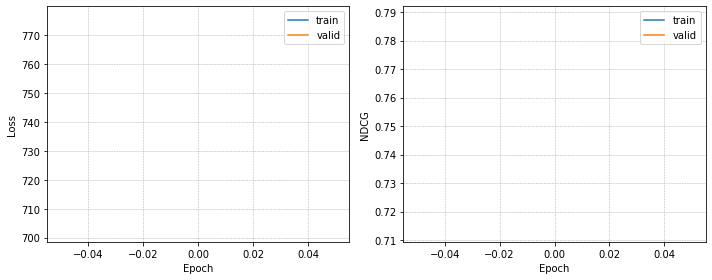

In [146]:
# train loop
def plot_loss_ndcg(train_loss, valid_loss, train_ndcg, valid_ndcg):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    
    ax1.plot([np.mean(train_loss[epoch]) for epoch in train_loss], label='train')
    ax1.plot([np.mean(valid_loss[epoch]) for epoch in valid_loss], label='valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2.plot([np.mean(train_ndcg[epoch]) for epoch in train_ndcg], label='train')
    ax2.plot([np.mean(valid_ndcg[epoch]) for epoch in valid_ndcg], label='valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('NDCG')
    
    
    
    ax1.grid(linewidth=0.5, linestyle='--')
    ax1.legend()
    
    ax2.grid(linewidth=0.5, linestyle='--')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_loss_ndcg(train_loss, valid_loss, train_ndcg, valid_ndcg)
